In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colormaps, patches
from tqdm import tqdm
import pickle

# module containing the main functions
import utils as ut

# Phase diagram varying $\tau_{crit}$ and $\alpha_0$ 

In [2]:
def stop_cond_memory(trajs, pars):
    """
    Stop condition of having the positive growth rate theta times smaller 
    than gamma
    """
    Ts, P, Ss = trajs[-1]
    growth_rates = pars.betas * P * (1 - Ss)
    gr_small_than_th = np.sum(growth_rates / pars.gamma < theta)
    return gr_small_than_th >= pars.n

def stop_cond_peak(trajs, pars):
    """
    Stop condition of being at the stationary point of total T cell abundance
    """
    if len(trajs) < 2: return False
    Ts1, _, _ = trajs[-1]
    Ts0, _, _ = trajs[-2]
    delta_T_tot = np.sum(Ts1) - np.sum(Ts0)
    return delta_T_tot < 0

def generate_ensamble(R, tau_sampler, stop_cond, **params):
    # Initializing parameters with default values or corrected through **params
    pars = ut.TT_params([1], **params)

    #progress = tqdm(total=R)
    taus_mat, Tfreqs_mat, T_tot_mat, times_mat = [], [], [], []
    for _ in range(R):
        tau_sampler.sample()
        pars.set_taus(tau_sampler.taus)
        times, T_trajs, _, _ = ut.run_setting(pars, tau_sampler, t_steps, dt, traj_steps=traj_steps, stop_cond=stop_cond)
    
        T_tot_mat.append(np.sum(T_trajs, axis=1))
        times_mat.append(times)
        no_extinct = T_trajs[-1] >= 1
        freqs = T_trajs[-1] / T_trajs[-1].sum()
        Tfreqs_mat.append(freqs[no_extinct])
        taus_mat.append(tau_sampler.taus[no_extinct])
        #progress.update(1)
        
    return taus_mat, Tfreqs_mat, T_tot_mat, times_mat

def find_first_zero(xs, ys):
    for i in range(1, len(xs)):
        x0, y0, x1, y1 = xs[i-1], ys[i-1], xs[i], ys[i]
        if y0*y1 < 0:
            # Linear interpolation to get the zero
            x_max = x1 + y1*(x0-x1)/(y1-y0)
            return x_max
    return float('nan')

def find_max(taus_mat, Tfreqs_mat, smooth_bins=30):
    """
    Method for detecting an average maximum in an ensemble of tau-freq curves
    """
    if any(np.array([len(t) < 2 for t in taus_mat])):
        return float('nan'), float('nan'), 0, 'extinct'
    
    # Moving to the log transformed variables, sorting them and taking the derivative
    logtaus, logTfreq = [np.log10(t) for t in taus_mat], [np.log10(t) for t in Tfreqs_mat]
    tau_sort_i = [np.argsort(t) for t in logtaus]
    logtaus = [logtaus[i][tau_sort_i[i]] for i in range(len(logtaus))]
    logTfreq = [logTfreq[i][tau_sort_i[i]] for i in range(len(logTfreq))]
    ders = [(logTfreq[i][1:] - logTfreq[i][:-1]) / (logtaus[i][1:] - logtaus[i][:-1]) for i in range(len(logtaus))]
    mid_logtaus = [(logtaus[i][1:] + logtaus[i][:-1]) / 2.0 for i in range(len(logtaus))]

    # Computing the average trajectory
    bins = np.linspace(np.min(np.concatenate(mid_logtaus)), np.max(np.concatenate(mid_logtaus)), smooth_bins)
    smooth_x, smooth_y, _, _ = ut.binning_x(np.concatenate(mid_logtaus), np.concatenate(ders), bins)

    # Finding the zero of the smoothed trajectory
    x_max = find_first_zero(smooth_x, smooth_y)
    if np.isnan(x_max):
        return x_max, float('nan'), 0, 'no_maximum'

    # Counting how many trajectories cross the average maximum and are decreasing at the end
    logtaus_end = np.array([t[-1] for t in logtaus])
    ders_end = np.array([d[-1] for d in ders])
    max_mask = np.logical_and(logtaus_end > x_max, ders_end < 0)
    n_x_max = np.sum(max_mask)
    
    # Estimating the average y at max
    y_maxs = []
    for r in range(len(taus_mat)):
        if max_mask[r]:
            y_maxs.append(np.interp(x_max, logtaus[r], logTfreq[r]))
    y_max = np.mean(y_maxs)
    
    return x_max, y_max, n_x_max, 'maximum'

def compute_inv_simps(T_freqs_mat):
    """Compute the inverse Simpson's index for a list of frequency arrays."""
    inv_simps = np.array([1 / np.sum(freqs**2) for freqs in T_freqs_mat])
    inv_simps = inv_simps[~np.isnan(inv_simps)]
    inv_simps = inv_simps[~np.isinf(inv_simps)]
    return np.mean(inv_simps)

In [9]:
# Parameters

# Sampling taus from lognormal with default parameters
tau_samp = ut.tau_sampler_lognorm()

# Integration parameters
t_steps, dt, traj_steps = 1000, 'adapt', 30

# Memory stopping condition parameter
theta = 0.2  

# Fraction of ensambles with maximum to determine the non-monotoncity
no_max_perc = 0.8

# Minimal expansion factor
min_expans = 2

# Minimal frequency at maximum
#min_freq_max = 2 / tau_samp.n_samples

# Number of realizations in an ensemble
R = 300

In [ ]:
# Computing the diagram (long time). Results saved in 'out_data/<name>.pkl'

# Defining the grid tau critical - alpha0
tau_crits = np.logspace(-2, 1, 30)
alpha0s = np.logspace(-6, -2, 30)
sh = (len(tau_crits), len(alpha0s))

# Initializing matrices to store results
x_max_mat, y_max_mat, simps_mat = np.zeros(sh), np.zeros(sh), np.zeros(sh)
Ttot_mat, outcome_mat, frac_nomax_mat = np.zeros(sh), np.zeros(sh, dtype='U10'), np.zeros(sh)
progress = tqdm(total=len(tau_crits)*len(alpha0s))

# Computing the phase diagram
for i, tau_c in enumerate(tau_crits):
    for j, alpha0 in enumerate(alpha0s):
        taus_mat, Tfreqs_mat, T_tot_mat, times_mat = generate_ensamble(R, tau_samp, stop_cond_memory, alpha0=alpha0, tau_crit=tau_c)
        x_max, y_max, n_x_max, outcome = find_max(taus_mat, Tfreqs_mat)
        x_max_mat[i,j], y_max_mat[i,j] = x_max, y_max
        outcome_mat[i,j], frac_nomax_mat[i,j] = outcome, (R - n_x_max) / R
        Ttot = np.mean([np.max(Ttot) for Ttot in T_tot_mat])
        simps_mat[i,j], Ttot_mat[i,j] = compute_inv_simps(Tfreqs_mat), Ttot
        progress.update(1)

# Saving data
name = 'phase_diagram_' + str(len(tau_crits)*len(alpha0s))
with open(f'out_data/{name}.pkl', 'wb') as f:
    pickle.dump((tau_crits, alpha0s, x_max_mat, y_max_mat, simps_mat, Ttot_mat, outcome_mat, frac_nomax_mat), f)

# Saving parameters
pars = ut.TT_params([1])  # just to have access to default parameters
tau_samp = ut.tau_sampler_lognorm() 
other_params = {'theta_stop': theta, 'no_max_perc': no_max_perc, 'min_expans': min_expans, 'R' : R}
other_params = {**tau_samp.get_pars(), **other_params}
pars.print_on_file('out_data', name, other_params)

 67%|██████▋   | 6/9 [00:14<00:07,  2.36s/it]/tmp/ipykernel_21387/1852536433.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  inv_simps = np.array([1 / np.sum(freqs**2) for freqs in T_freqs_mat])
100%|██████████| 9/9 [00:19<00:00,  1.64s/it]

In [7]:
name = 'phase_diagram_225'

# Importing the parameters
params = pd.read_csv(f'out_data/{name}.tsv', sep='\t', header=None, index_col=0)[1].to_dict()

# Importing the data and applying thresholds for plotting
data = pickle.load(open(f'out_data/{name}.pkl', 'rb'))
tau_crits, alpha0s, x_max_mat, y_max_mat, simps_mat, Ttot_mat, outcome_mat, frac_nomax_mat = data

# Appling the thresholds
outcome_mat[frac_nomax_mat > no_max_perc] = 'no_maximum'
outcome_mat[Ttot_mat < min_expans * tau_samp.n_samples] = 'extinct'

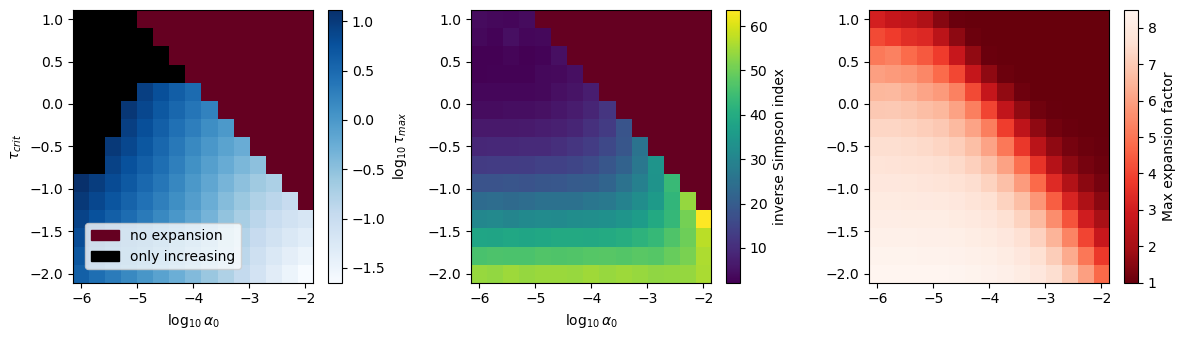

In [8]:
# Plotting the phase diagrams

def add_phases(ax, extent, color1='#650021', color2='k', add_increasing=True, legend=False):
    """Add phase regions to a given axis."""
    cm1 = plt.cm.colors.ListedColormap([color1])
    cm2 = plt.cm.colors.ListedColormap([color2])
    aux_mat = np.where(outcome_mat == 'extinct', 1.0, float('nan'))
    ax.imshow(aux_mat[::-1], cmap=cm1, vmin=0, extent=extent, aspect='auto')

    if add_increasing:
        aux_mat = np.where(outcome_mat == 'no_maximum', 1.0, float('nan'))
        ax.imshow(aux_mat[::-1], cmap=cm2, vmin=0, extent=extent, aspect='auto')

    patch1 = patches.Patch(color=color1, label='no expansion')
    patch2 = patches.Patch(color=color2, label='only increasing')
    if legend:
        ax.legend(handles=[patch1, patch2], bbox_to_anchor=(0.05, 0.05), loc=3, borderaxespad=0.)
    
    return ax


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3.5))

xs, ys = np.log10(alpha0s), np.log10(tau_crits)
extent = (xs[0] - (xs[1]-xs[0])/2, xs[-1] + (xs[1]-xs[0])/2, ys[0] - (ys[1]-ys[0])/2, ys[-1] + (ys[1]-ys[0])/2)

aux_mat = np.where(outcome_mat == 'maximum', x_max_mat, float('nan'))
ax1.imshow(aux_mat[::-1], extent=extent, aspect='auto', cmap='Blues')
ax1 = add_phases(ax1, extent, legend=True)
ax1.set_xlabel(r'$\log_{10}\alpha_{0}$')
ax1.set_ylabel(r'$\tau_{crit}$')
cb1 = fig.colorbar(ax1.images[0], ax=ax1)
cb1.set_label(r'$\log_{10}\tau_{max}$')

aux_mat = np.where(outcome_mat != 'extinct', simps_mat, float('nan'))
ax2.imshow(aux_mat[::-1], extent=extent, aspect='auto')
ax2 = add_phases(ax2, extent, add_increasing=False)
ax2.set_xlabel(r'$\log_{10}\alpha_{0}$')
#ax2.set_ylabel(r'$\tau_{crit}$')  
cb2 = fig.colorbar(ax2.images[0], ax=ax2)
cb2.set_label('inverse Simpson index')

ax3.imshow(Ttot_mat[::-1] / params['n_samples'], extent=extent, aspect='auto', cmap='Reds_r')
ax2.set_xlabel(r'$\log_{10}\alpha_{0}$')
#ax2.set_ylabel(r'$\tau_{crit}$')  
cb3 = fig.colorbar(ax3.images[0], ax=ax3)
cb3.set_label('Max expansion factor')

plt.tight_layout()

plt.savefig('plots/'+name+'.svg', dpi=200, facecolor='w')